# Sensitivity of trends to current definitions
work on one current at a time

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs, feature
import cmocean as cm
import matplotlib.lines as mlines

import warnings
warnings.filterwarnings("ignore")

IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [5]:
obs = pd.read_csv(IOPATH).drop(columns=['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0','NO2 (uM)', 'NH4 (uM)', 'Nstar (umol kg-1)', 'PO4 (uM)',
       'SiO4 (uM)', 'Chl (mg m-3)','Carbonate','Aragonite', 'Calcite', 'Cd (nmol kg-1)', 'Co (nmol kg-1)',
       'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)', 'Ni (nmol kg-1)','Zn (nmol kg-1)'])

In [6]:
obs.columns

Index(['time', 'longitude (degrees_east)', 'latitude (degrees_north)',
       'depth (m)', 'pressure (dbar)', 'temperature (degC)',
       'salinity (g kg-1)', 'density (kg m-3)', 'spice', 'sigma0 (kg m-3)',
       'DO (umol kg-1)', 'NO3 (uM)', 'TA (uM)', 'DIC (uM)', 'source',
       'current', 'location', '[TA-DIC] (uM)', 'year', 'month', 'NSdist',
       'EWdist'],
      dtype='object')

In [74]:
##################
# Trends in time #
##################

def plot_ratediff_NS_CI(obs_used,var_string, ax, colour, *,
                        CC = False, n_bins=9, cov_type="HAC", hac_maxlags=1,
                        annual_stat="median", min_obs_per_year=3,
                        min_years=4, min_span_years=10, offset=0):

    ylim_dict = {'spice':[-0.03,0.02], 'temperature (degC)': [-0.12,0.12],
                 'salinity (g kg-1)':[-0.015,0.015], 'DO (umol kg-1)':[-3.7,3],
                 'NO3 (uM)':[-1.5,0.5], '[TA-DIC] (uM)':[-10,14]}

    # bin edges/centers/widths
    dist = np.asarray(obs_used['dist'])
    dmin, dmax = -1415, 2950
    edges   = np.linspace(dmin, dmax, n_bins+1)
    centers = 0.5 * (edges[:-1] + edges[1:]) + offset

    slopes      = np.full(n_bins, np.nan)
    lo95        = np.full(n_bins, np.nan)
    hi95        = np.full(n_bins, np.nan)
    year_span   = np.full(n_bins, np.nan)   # NaN => excluded
    n_years_arr = np.full(n_bins, np.nan)

    years_all = np.asarray(obs_used['year'])
    y_all     = np.asarray(obs_used[var_string])

    for i in range(n_bins):
        lo, hi = edges[i], edges[i+1]
        msk = (dist >= lo) & (dist < hi) & np.isfinite(years_all) & np.isfinite(y_all)
        if not np.any(msk):
            continue

        # (1) aggregate to annual values with ≥ min_obs_per_year
        df_bin = pd.DataFrame({
            "year": years_all[msk].astype(float),
            "val":  y_all[msk].astype(float)
        })

        # distinct years and span
        n_years = len(set(df_bin["year"]))
        span = float(df_bin["year"].max() - df_bin["year"].min() + 1)

        if (n_years < min_years) or (span < min_span_years):
            # exclude this bin from both points and bars
            continue

        grp = df_bin.groupby("year", as_index=False).agg(
            n=("val", "size"),
            med=("val", "median"),
            mean=("val", "mean")
        )
        grp = grp[grp["n"] >= min_obs_per_year]
        if grp.empty:
            continue

        n_years_arr[i] = n_years
        year_span[i]   = span

        Y_ann = grp["med"].values if annual_stat == "median" else grp["mean"].values
        X_ann = grp["year"].values

        # (2) OLS with equal weight per year + (3) robust SEs
        X = sm.add_constant(X_ann)
        ols = sm.OLS(Y_ann, X)
        if cov_type == "HAC":
            res = ols.fit(cov_type="HAC", cov_kwds={"maxlags": int(hac_maxlags)})
        else:
            res = ols.fit(cov_type=cov_type)

        slopes[i] = res.params[1]
        ci = res.conf_int(alpha=0.05)
        if ci.shape[0] > 1:
            lo95[i], hi95[i] = ci[1, 0], ci[1, 1]

    # group 1: year_span >= 20 (solid)
    m_long = (np.isfinite(slopes) & np.isfinite(lo95) & np.isfinite(hi95) &
              np.isfinite(year_span) & (year_span >= 20))
    if np.any(m_long):
        yerr = np.vstack([hi95[m_long] - slopes[m_long], slopes[m_long] - lo95[m_long]])
        ax.errorbar(centers[m_long], slopes[m_long], yerr=yerr, fmt='.', ms=7,
                       c=colour,zorder=4)

    # group 2: year_span < 20 (faded)
    m_short = (np.isfinite(slopes) & np.isfinite(lo95) & np.isfinite(hi95) &
               np.isfinite(year_span) & (year_span < 20))
    if np.any(m_short):
        yerr = np.vstack([hi95[m_short] - slopes[m_short], slopes[m_short] - lo95[m_short]])
        ax.errorbar(centers[m_short], slopes[m_short], yerr=yerr, fmt='.', ms=7,
                       c=colour,alpha=0.35,zorder=4)

    ax.set_xlim(dmin, dmax)
    ax.set_xticks([-1000,-500,0,500,1000,1500,2000,2500])
    ax.set_xticklabels(['','-500','','500','','1500','','2500'],rotation=90)
    ax.axhline(0, color='black', lw=1,zorder=3)

    secax = ax.secondary_xaxis('top')
    secax.set_xlim(dmin, dmax)
    secax.set_xticks([-1000,-500,0,500,1000,1500,2000,2500])
    if CC == True:
        secax.set_xticklabels(['','-133.3$^\circ$ E','','43.3$^\circ$ N','','35.2$^\circ$ N','','28.6$^\circ$ N'],rotation=90)
    else:
        secax.set_xticklabels(['','51.0$^\circ$ N','','43.3$^\circ$ N','','35.2$^\circ$ N','','28.6$^\circ$ N'],rotation=90)

    if var_string in ylim_dict:
        ax.set_ylim(ylim_dict[var_string])

    # add lines for JdF, Cape Mendocino, and Point Conception
    # ax.plot([0,0],[-1000,1000],'k--',alpha=0.5) # JdF
    ax.plot([805,805],[-1000,1000],'k--',alpha=0.5) # Cape Mendocino
    ax.plot([1654,1654],[-1000,1000],'k--',alpha=0.5) # Point Conception
    # ax.text(0.34,0.02,'SS',ha='right',va='bottom',transform=ax.transAxes,fontsize=10)
    ax.text(0.65,0.02,'CM',ha='right',va='bottom',transform=ax.transAxes,fontsize=10)
    ax.text(0.82,0.02,'PC',ha='right',va='bottom',transform=ax.transAxes,fontsize=10)
    
    ax.set_zorder(3)
    ax.patch.set_alpha(0)

## CUC
starting with the CUC bc it feels the most straightforward

In [11]:
# the main option for the CUC has already been defined
cuc1 = obs[obs['current'] == 'CUC']
cuc1['dist'] = cuc1.NSdist

# defined as measurements collected over the continental slope, between 25 and 52 N, and within the 26.45-26.6 g/kg isopycnal range
# what makes sense to play around with here is if we confined the isopycnal range more to check that the range I chose isn't too broad
# range 2 = 26.45-26.55
# range 3 = 26.50-26.60

# since these are within the current CUC bounds we can work with the cuc1 dataset
cuc2 = cuc1[(cuc1['sigma0 (kg m-3)']<=26.55)]
cuc3 = cuc1[(cuc1['sigma0 (kg m-3)']>=26.50)]

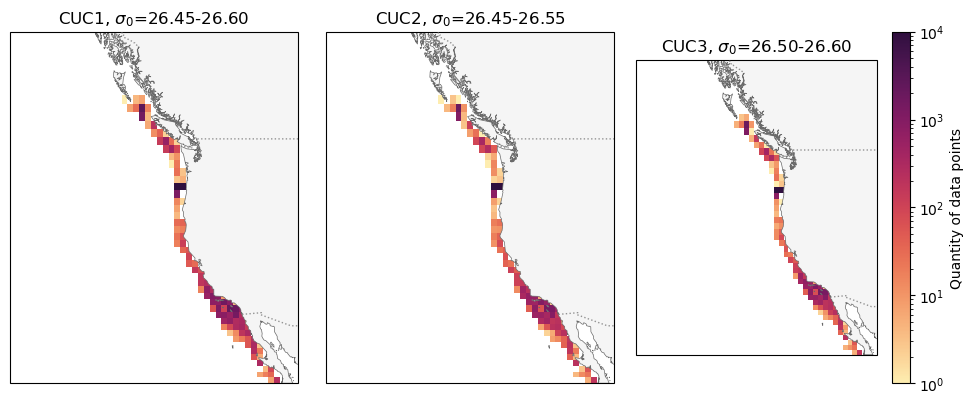

In [23]:
# plot extent

############
# ALL MAPS #
############

xlim, ylim = [-146, -110.2], [25, 57]
proj= crs.Mercator(np.mean(xlim), *ylim)
fig, ax = plt.subplots(1,3,figsize=(10,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

xbin = np.linspace(xlim[0],xlim[1],50)
ybin = np.linspace(ylim[0],ylim[1],50)
vmin,vmax = 1,10000

########
# CUC1 #
########
ax[0].set_title("CUC1, $\sigma_0$=26.45-26.60")

lon = cuc1['longitude (degrees_east)']
lat = cuc1['latitude (degrees_north)']

# Create 2D histogram
hist1, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)
# only need to do this once bc bins are the same for all three plots

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist1.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


########
# CUC2 #
########
ax[1].set_title("CUC2, $\sigma_0$=26.45-26.55")

lon = cuc2['longitude (degrees_east)']
lat = cuc2['latitude (degrees_north)']

# Create 2D histogram
hist2, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist2.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


########
# CUC3 #
########
ax[2].set_title("CUC3, $\sigma_0$=26.50-26.60")

lon = cuc3['longitude (degrees_east)']
lat = cuc3['latitude (degrees_north)']

# Create 2D histogram
hist3, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[2].pcolormesh(X, Y, hist3.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[2], location='right',orientation='vertical',label="Quantity of data points")

plt.tight_layout()

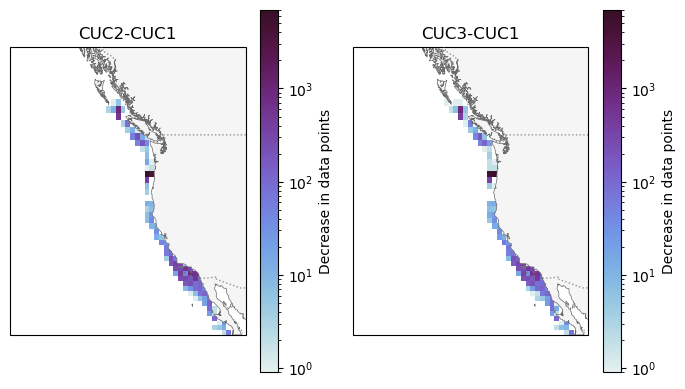

In [37]:
fig, ax = plt.subplots(1,2,figsize=(7,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

vmin,vmax = 7000,1

#############
# CUC2-CUC1 #
#############
ax[0].set_title("CUC2-CUC1")

hist=hist1-hist2

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Decrease in data points")

#############
# CUC3-CUC1 #
#############
ax[1].set_title("CUC3-CUC1")

hist=hist1-hist3

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[1], location='right',orientation='vertical',label="Decrease in data points")

plt.tight_layout()

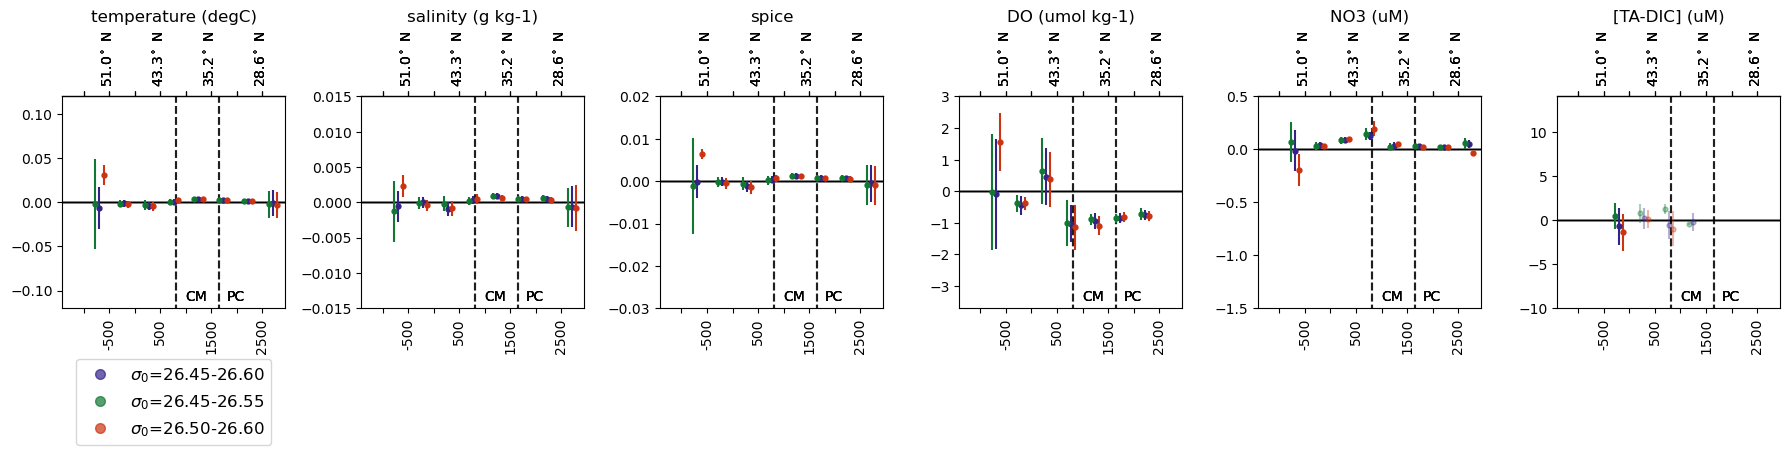

In [75]:
# now looking at how trends change with this new definition
varstrings = ['temperature (degC)','salinity (g kg-1)', 'spice',
       'DO (umol kg-1)', 'NO3 (uM)','[TA-DIC] (uM)']

fig,ax = plt.subplots(1,len(varstrings),figsize=[3*len(varstrings),5])

for i in range(len(varstrings)):

    ax[i].set_title(varstrings[i])
    plot_ratediff_NS_CI(cuc1,varstrings[i], ax[i], '#332288')
    plot_ratediff_NS_CI(cuc2,varstrings[i], ax[i], '#117733',offset=-80)
    plot_ratediff_NS_CI(cuc3,varstrings[i], ax[i], '#CC3311',offset=80)


# # build legend handles    
legend_handles = []
inlegend = ["$\sigma_0$=26.45-26.60",'$\sigma_0$=26.45-26.55','$\sigma_0$=26.50-26.60']
colours = ['#332288', '#117733', '#CC3311']
markers = ['o','o','o']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
ax[0].legend(handles=legend_handles, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=12)

plt.tight_layout()